In [1]:
# References:
# - https://www.jeremyjordan.me/semantic-segmentation/#loss
# - Writeup of the #1 solution and the case study (linked from the above)
# - https://glassboxmedicine.com/2020/01/21/segmentation-u-net-mask-r-cnn-and-medical-applications/ READ THIS

In [1]:
# Structure:
# - Use data from the data science bowl
# - Build things up slowly
# - Data exploration
#   - Where did this data come from?
#   - What kind of cells are these? Why is it important to detect nuclei?
#   - Why are some in color and some not in color?
#   - How many are in color, how many aren't?
#   - What are the different sizes 
# - Problem formulation and metric design
#   - Is this the instance version or not?
#   - What metrics make sense?
#   - Code for a model interface, quantitative evaluation, and error analysis
# - Baselines
#   - Random output
#   - Classical computer vision techniques
#   - Shallow convolutional networks
# - Simple techniques for improving on the baseline  
#   - Data augmentation
#   - Post processing
# - Improving on the baseline through better network architectures
#   - Simple UNet
#   - Best practice UNet
#   - 

from collections import defaultdict
import logging
import os
from pathlib import Path
import pickle
import random
import sys
import warnings

import imagecodecs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from skimage.color import rgb2gray, gray2rgb
from skimage.io import imread, imsave, imshow
from skimage.measure import find_contours
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

os.environ["WANDB_SILENT"] = "true"
import wandb

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

CN_PATH = 'data/cell-nuclei-kaggle/stage1/train/'
CACHE_PATH = 'data/cache'

# Create CACHE_PATH if it doesn't already exist
Path(CACHE_PATH).mkdir(parents=True, exist_ok=True)

# Simple wrapper for tqdm to give a good default width.
def stqdm(iterator, **kwargs):
    return tqdm(iterator, bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}', **kwargs)

_ = wandb.login()
logging.getLogger("lightning").setLevel(logging.ERROR)

In [3]:
# Where did this data come from?

# https://bbbc.broadinstitute.org/BBBC038
# Full paper describing motivation and results: https://personal.broadinstitute.org/anne/publications/127_Caicedo_NatMethods_2019.pdf

# Motivation comes from this video: https://datasciencebowl.com/2018dsbtutorial/
# High level idea: identifying cells automatically is a key step toward high-throughput testing of compounds.
# We already have robots that can add automate the mechanical aspects of the experiments, but we need
# computer vision solutions to automate the analysis part of the experiment.

# Why find a nucleus instead of the whole cell? It's the most easily distinguished part of the cell,
# especially if the cell is given a dye that lights up DNA. Once the nucleus is identified,
# then the rest of the cell can be analyzed more easily.

# There are already algorithms used in practice to detect nuclei, but they tend to be classical computer vision
# algorithms. But these
# - don't perform well in messy images, e.g. where nuclei overlap or an entire tissue sample is present
# - need to be tuned to specific equipment and stains

# Key goal is robustness

In [4]:
# Let's explore our first data set. This is coming from the 2018 Data Science Bowl.
# To keep things simple, we'll focus only on the training set (and split out some
# of the training data for validation). This omits the key motivation for the
# Data Science Bowl challenge, which was to develop a single classifier that generalizes
# well to new distributions of data, based on changes in experimental setup, cell type, etc.
# But for our purposes of gaining intuition around various segmentation algorithms,
# it will suffice.

Num cell nuclei examples: 670


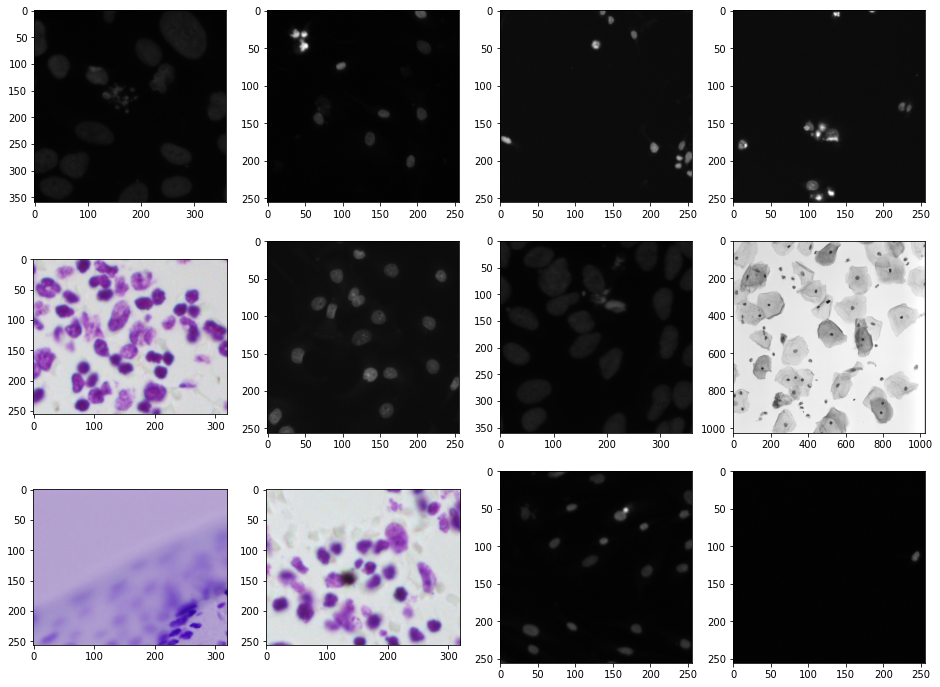

In [2]:
# First, let's take a look at a random sample of the cell nuclei images to get a sense for what we're working with.

cn_ids = next(os.walk(CN_PATH))[1]
print('Num cell nuclei examples: {}'.format(len(cn_ids)))

random.seed(906)
rand_ids = random.sample(cn_ids, 12)
_, subaxes = plt.subplots(3, 4, figsize=(16, 12))
subaxes = subaxes.flatten()
for i, id_ in enumerate(rand_ids):
    img = imread(CN_PATH + id_ + '/images/' + id_ + '.png')
    subaxes[i].imshow(img)

Immediately, we observe that this data is fairly messy:
- The images come in different sizes
- Some are color images and some are grayscale
- There are various levels of focus of the cell nuclei
- It appears that different microscopes, staining techniques, and even cell types were used.

The messiness of this data is by design. It's representative of the type of heterogeneity
drug development researchers observe regularly, and the organizers of the competition wanted
to see whether a single algorithm could be developed that generalized across images like this.

The labels for these images consist of one image mask per nucleus.
The objective of the competition was to separately identify each nucleus
rather than a single mask for the image that indicated whether a
nucleus was present or not. Thus, it was an "instance segmentation" task
rather than a "segmentation" task. This was because (1) the segmentation
problem (i.e. just distinguishing foreground from background) is relatively easy
and (2) downstream applications (such as cell counting) needed to have each
nucleus separately identified.

But for our purposes, we'll start with the simpler segmentation task. That
means we'll need to merge the individual nucleus-level masks into a single
mask for the image.

We're now ready to load the images and masks from disk into memory. The process
of combining masks and resizing images to a uniform size is somewhat slow,
so we'll load from a cache if possible. To simplify things, we'll
convert all images to grayscale.

In [3]:
IMG_HEIGHT = 128
IMG_WIDTH = 128

def load_from_cache_if_exists(cache_path, obj):
    if os.path.exists(cache_path):
        with open(cache_path, 'rb') as fp:
            obj = pickle.load(fp)
    return obj

cn_images_cache_path = os.path.join(CACHE_PATH, 'cn_images.pickle')
cn_images = load_from_cache_if_exists(cn_images_cache_path, [])


if len(cn_images) == 0:
    for id_ in stqdm(cn_ids):
        img = imread(os.path.join(CN_PATH, id_, 'images', id_ + '.png'))
        
        # Some of the images are rgba. We just discard the last dimension.
        img = img[:, :, :3]

        # Convert to grayscale and scale to a uniform size of 256x256
        img = rgb2gray(img)
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

        cn_images.append(img)
    
    with open(cn_images_cache_path, 'wb') as fp:
        pickle.dump(cn_images, fp)


cn_masks_cache_path = os.path.join(CACHE_PATH, 'cn_masks.pickle')
cn_masks = load_from_cache_if_exists(cn_masks_cache_path, [])

if len(cn_masks) == 0:
    for id_ in stqdm(cn_ids):
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH))
        masks_dir = os.path.join(CN_PATH, id_, 'masks')
        for mask_file in next(os.walk(masks_dir))[2]:
            mask_ = imread(os.path.join(masks_dir, mask_file))
            mask_ = resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
            mask = np.maximum(mask, mask_)
        mask = (mask > 0).astype('float64')
        
        cn_masks.append(mask)
        
    with open(cn_masks_cache_path, 'wb') as fp:
        pickle.dump(cn_masks, fp)

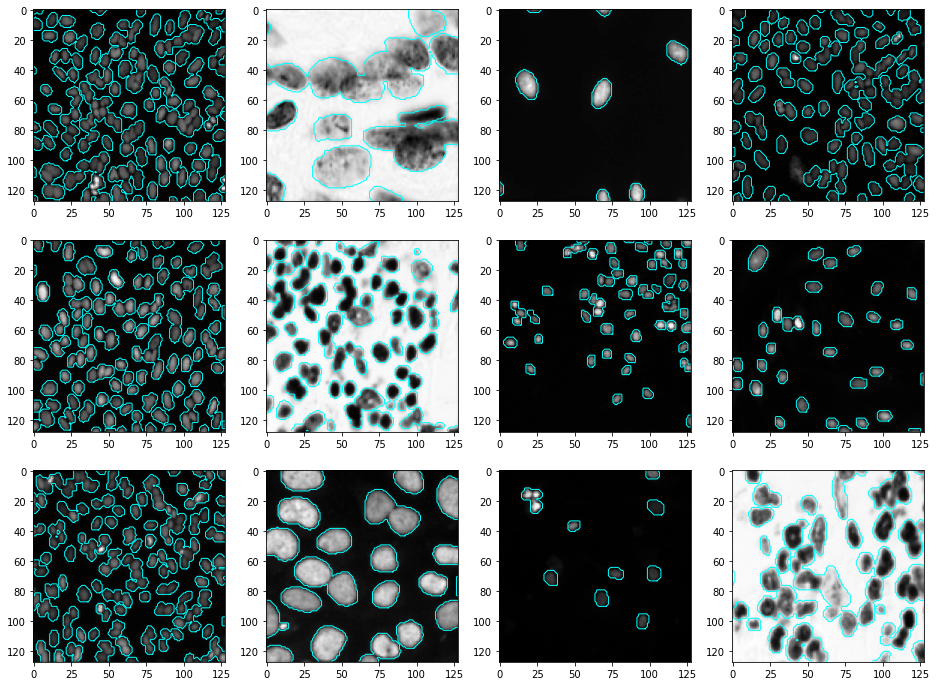

In [4]:
# Let's look some random images after they've been processed.
# We'll look at 12 images, and for each image we'll display its
# corresponding mask directly beneath it.
random.seed(36)

def show_overlayed_mask(mask, ax, color='cyan'):
    contours = find_contours(mask)
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], color=color, linewidth=1)

rand_ids = random.sample(range(len(cn_images)), 12)

_, subaxes = plt.subplots(3, 4, figsize=(16, 12))
subaxes = subaxes.flatten()
for i, img_idx in enumerate(rand_ids):
    subaxes[i].imshow(cn_images[img_idx], cmap='Greys_r')
    show_overlayed_mask(cn_masks[img_idx], subaxes[i])

In [5]:
X_cn = np.stack(cn_images).astype(np.float32)
Y_cn = np.stack(cn_masks).astype(np.float32)
X_cn_train, X_cn_val, Y_cn_train, Y_cn_val = train_test_split(X_cn, Y_cn, test_size=0.2, random_state=609)

In [6]:
# Nerve segmentation data
# https://www.kaggle.com/c/ultrasound-nerve-segmentation/data

NERVE_PATH = 'data/ultrasound-nerve-segmentation/'

# Load metadata about the train set
train_mask_df = pd.read_csv(os.path.join(NERVE_PATH, 'train_masks.csv'))
nerve_img_info = defaultdict(dict)
for idx, row in train_mask_df.iterrows():
    nerve_img_info[row['subject']][row['img']] = not pd.isna(row['pixels'])

all_sub_img_pairs = [(sub_idx, img_idx) for sub_idx in nerve_img_info for img_idx in nerve_img_info[sub_idx]]

num_subjects = len(nerve_img_info)
num_images = len(all_sub_img_pairs)
num_images_with_nerve = len([
    (sub_idx, img_idx) for (sub_idx, img_idx) in all_sub_img_pairs if nerve_img_info[sub_idx][img_idx]])
    
print('Number of subjects: {}'.format(num_subjects))
print('Number of images: {}'.format(num_images))
print('Number of images with nerve: {}'.format(num_images_with_nerve))

Number of subjects: 47
Number of images: 5635
Number of images with nerve: 2323


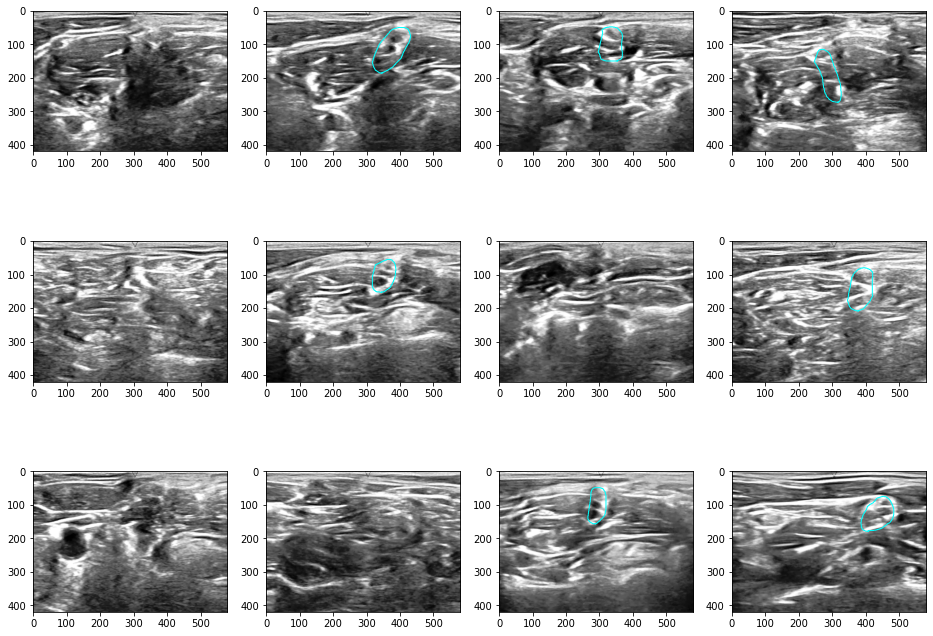

In [7]:
# Let's again load 12 random images and visualize them with their corresponding masks

def load_nerve_image(sub_idx, img_idx):
    path = os.path.join(NERVE_PATH, 'train', '{}_{}.tif'.format(sub_idx, img_idx))
    return imread(path)

def load_nerve_mask(sub_idx, img_idx):
    path = os.path.join(NERVE_PATH, 'train', '{}_{}_mask.tif'.format(sub_idx, img_idx))
    return imread(path)

random.seed(3)

rand_pairs = random.sample(all_sub_img_pairs, 12)

    
_, subaxes = plt.subplots(3, 4, figsize=(16, 12))
subaxes = subaxes.flatten()
for i, (sub_idx, img_idx) in enumerate(rand_pairs):
    subaxes[i].imshow(load_nerve_image(sub_idx, img_idx), cmap='Greys_r')
    show_overlayed_mask(load_nerve_mask(sub_idx, img_idx), subaxes[i])

In [8]:
# Now let's split into train and validation sets (by subject) and resize to 256x256

# Load all of the nerve images into memory, and resize them to 256x256, so they are the same
# size as the cell nucleus images.

nerve_images_cache_path = os.path.join(CACHE_PATH, 'nerve_images.pickle')
nerve_images = load_from_cache_if_exists(nerve_images_cache_path, defaultdict(dict))

if len(nerve_images) == 0:
    for sub_idx in stqdm(nerve_img_info):
        for img_idx in nerve_img_info[sub_idx]:
            img = load_nerve_image(sub_idx, img_idx)
            img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
            img = img / 256.0  # Convert to 0-1 scale

            nerve_images[sub_idx][img_idx] = img
    
    with open(nerve_images_cache_path, 'wb') as fp:
        pickle.dump(nerve_images, fp)

nerve_masks_cache_path = os.path.join(CACHE_PATH, 'nerve_masks.pickle')
nerve_masks = load_from_cache_if_exists(nerve_masks_cache_path, defaultdict(dict))

if len(nerve_masks) == 0:
    for sub_idx in stqdm(nerve_img_info):
        for img_idx in nerve_img_info[sub_idx]:
            mask = load_nerve_mask(sub_idx, img_idx)
            mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
            mask = (mask > 0).astype('float64')
        
            nerve_masks[sub_idx][img_idx] = mask
        
    with open(nerve_masks_cache_path, 'wb') as fp:
        pickle.dump(nerve_masks, fp)

In [9]:
# Split into train and validation sets
train_sub_ids, val_sub_ids = train_test_split(sorted(nerve_img_info.keys()), test_size=0.2, random_state=609)
X_nerve_train = np.stack([nerve_images[sub_idx][img_idx]
                          for (sub_idx, img_idx) in all_sub_img_pairs
                          if sub_idx in train_sub_ids]).astype(np.float32)
X_nerve_val = np.stack([nerve_images[sub_idx][img_idx]
                        for (sub_idx, img_idx) in all_sub_img_pairs
                        if sub_idx in val_sub_ids]).astype(np.float32)
Y_nerve_train = np.stack([nerve_masks[sub_idx][img_idx]
                          for (sub_idx, img_idx) in all_sub_img_pairs
                          if sub_idx in train_sub_ids]).astype(np.float32)
Y_nerve_val = np.stack([nerve_masks[sub_idx][img_idx]
                        for (sub_idx, img_idx) in all_sub_img_pairs
                        if sub_idx in val_sub_ids]).astype(np.float32)

In [10]:
def compute_metrics(Y_true, Y_pred):
    assert Y_true.shape == Y_pred.shape
    n = Y_true.shape[0]
    ious = []
    dices = []
    for i in range(n):
        intersection = np.logical_and(Y_true[i, :, :], Y_pred[i, :, :])
        union = np.logical_or(Y_true[i, :, :], Y_pred[i, :, :])
        ious.append(np.sum(intersection) / float(np.sum(union)))
        dices.append(2. * np.sum(intersection) / (np.sum(Y_true[i, :, :]) + np.sum(Y_pred[i, :, :])))
    return np.mean(ious), np.mean(dices), ious, dices

np.random.seed(821)

Y_cn_pred = np.ones(Y_cn_val.shape)
mean_iou, mean_dice, _, _ = compute_metrics(Y_cn_pred, Y_cn_val)

print('Model: predicting all 1s')
print('IoU:  {:.3f}'.format(mean_iou))
print('Dice: {:.3f}'.format(mean_dice))

Y_nerve_pred = np.ones(Y_nerve_val.shape)
mean_iou, mean_dice, _, _ = compute_metrics(Y_nerve_pred, Y_nerve_val)

print('Model: predicting all 1s')
print('IoU:  {:.3f}'.format(mean_iou))
print('Dice: {:.3f}'.format(mean_dice))

Model: predicting all 1s
IoU:  0.193
Dice: 0.298
Model: predicting all 1s
IoU:  0.016
Dice: 0.030


In [11]:
def iou(Y_true, Y_pred):
    # Define a torch version of iou so it can be logged by PyTorch Lightning
    i = torch.logical_and(Y_true, Y_pred)
    u = torch.logical_or(Y_true, Y_pred)
    i_sums = torch.sum(torch.sum(i, axis=2), axis=1)
    u_sums = torch.sum(torch.sum(u, axis=2), axis=1)
    return torch.mean(i_sums / u_sums)

class CNDataModule(pl.LightningDataModule):
    def setup(self, stage=None):
        self.train_data = TensorDataset(torch.from_numpy(X_cn_train), torch.from_numpy(Y_cn_train))
        self.val_data = TensorDataset(torch.from_numpy(X_cn_val), torch.from_numpy(Y_cn_val))
        self.predict_data = TensorDataset(torch.from_numpy(X_cn_val))
    
    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=16)
    
    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=16)

    def predict_dataloader(self):
        return DataLoader(self.predict_data, batch_size=16)

In [18]:
class SegmentationModelBase(pl.LightningModule):
    def __init__(self, lr=1e-3):
        super(SegmentationModelBase, self).__init__()
        self.lr = lr
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                # TODO: Play with the settings of this.
                'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer),
                'monitor': 'train/loss',
            }
        }
    
    def loss(self, Y, Y_pred):
        criterion = nn.BCEWithLogitsLoss()
        loss = criterion(torch.flatten(Y_pred, 1), torch.flatten(Y, 1))
        return loss
    
    def training_step(self, train_batch, batch_idx):
        X, Y = train_batch
        Y_pred = self.forward(X)
        loss = self.loss(Y, Y_pred)
        Y_pred_hat = Y_pred.detach() > 0.5
        self.log('train/loss', loss)
        self.log('train/iou', iou(Y, Y_pred_hat))
        return loss

    def validation_step(self, val_batch, batch_idx):
        X, Y = val_batch
        Y_pred = self.forward(X)
        loss = self.loss(Y, Y_pred)
        Y_pred_hat = Y_pred.detach() > 0.5
        self.log('val/loss', loss)
        self.log('val/iou', iou(Y, Y_pred_hat))

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        return self(batch[0])


class LinearBaseline(SegmentationModelBase):
    def __init__(self):
        super(LinearBaseline, self).__init__()
        self.single_weight = nn.Conv2d(1, 1, 1)

    def forward(self, X):
        X = X.unsqueeze(1)
        X = self.single_weight(X)
        X = X.squeeze()
        return X


wandb.init(project='test-segmentation')   

data_module = CNDataModule()

model = LinearBaseline()
trainer = pl.Trainer(gpus=1, logger=pl.loggers.WandbLogger(), max_epochs=100)
trainer.fit(model, data_module)
Y_cn_pred = torch.sigmoid(torch.cat(trainer.predict(model, datamodule=data_module), axis=0)).cpu().numpy() > 0.5

mean_iou, mean_dice, _, _ = compute_metrics(Y_cn_pred, Y_cn_val)

print('Model: basic U-Net')
print('IoU:  {:.3f}'.format(mean_iou))
print('Dice: {:.3f}'.format(mean_dice))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type   | Params
-----------------------------------------
0 | single_weight | Conv2d | 2     
-----------------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 34it [00:00, ?it/s]

Model: basic U-Net
IoU:  0.000
Dice: 0.000


In [44]:
class WeightedLossBaseline(SegmentationModelBase):
    def __init__(self):
        super(WeightedLossBaseline, self).__init__()
        Y_sum = Y_cn_train.sum()
        p = (Y_cn_train.shape[0] * IMG_HEIGHT * IMG_WIDTH - Y_sum) / Y_sum
        self.pos_weight = p * torch.ones(IMG_HEIGHT * IMG_WIDTH)

    def on_fit_start(self):
        self.pos_weight = self.pos_weight.to(self.device)

    def loss(self, Y, Y_pred):
        criterion = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)
        loss = criterion(torch.flatten(Y_pred, 1), torch.flatten(Y, 1))
        return loss

class LinearWithWeightedLoss(WeightedLossBaseline):
    def __init__(self):
        super(LinearWithWeightedLoss, self).__init__()
        self.single_weight = nn.Conv2d(1, 1, 1)

    def forward(self, X):
        X = X.unsqueeze(1)
        X = self.single_weight(X)
        X = X.squeeze()
        return X


wandb.init(project='test-segmentation')   

data_module = CNDataModule()

model = LinearWithWeightedLoss()
trainer = pl.Trainer(gpus=1, logger=pl.loggers.WandbLogger(), max_epochs=100)
trainer.fit(model, data_module)
Y_cn_pred = torch.sigmoid(torch.cat(trainer.predict(model, datamodule=data_module), axis=0)).cpu().numpy() > 0.5

mean_iou, mean_dice, _, _ = compute_metrics(Y_cn_pred, Y_cn_val)

print('Model: basic U-Net')
print('IoU:  {:.3f}'.format(mean_iou))
print('Dice: {:.3f}'.format(mean_dice))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type   | Params
-----------------------------------------
0 | single_weight | Conv2d | 2     
-----------------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/ubuntu/miniconda3/envs/unet/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:103: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f'The dataloader, {name}, does not have many workers which may be a bottleneck.'
/home/ubuntu/miniconda3/envs/unet/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:103: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f'The dataloader, {name}, does not have many workers which may be a bottleneck.'


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ubuntu/miniconda3/envs/unet/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:103: UserWarning: The dataloader, predict dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f'The dataloader, {name}, does not have many workers which may be a bottleneck.'


Predicting: 34it [00:00, ?it/s]

Model: basic U-Net
IoU:  0.477
Dice: 0.573


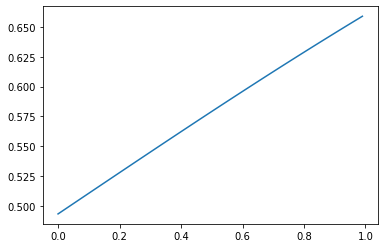

In [48]:
x = np.arange(0, 1, .01, dtype=np.float32)
y = torch.sigmoid(model(torch.from_numpy(x).unsqueeze(1).unsqueeze(1))).detach().numpy()
plt.plot(x, y)

In [49]:
class SimpleNonlinear(WeightedLossBaseline):
    def __init__(self):
        super(SimpleNonlinear, self).__init__()

        self.relu = nn.ReLU()
        self.layer1 = nn.Conv2d(1, 16, 1)
        self.layer2 = nn.Conv2d(16, 16, 1)
        self.layer3 = nn.Conv2d(16, 1, 1)

    def forward(self, X):
        X = X.unsqueeze(1)
        X = self.relu(self.layer1(X))
        X = self.relu(self.layer2(X))
        X = self.layer3(X)
        X = X.squeeze()
        return X


wandb.init(project='test-segmentation')   

data_module = CNDataModule()

model = SimpleNonlinear()
trainer = pl.Trainer(gpus=1, logger=pl.loggers.WandbLogger(), max_epochs=100)
trainer.fit(model, data_module)
Y_cn_pred = torch.sigmoid(torch.cat(trainer.predict(model, datamodule=data_module), axis=0)).cpu().numpy() > 0.5

mean_iou, mean_dice, _, _ = compute_metrics(Y_cn_pred, Y_cn_val)

print('Model: basic U-Net')
print('IoU:  {:.3f}'.format(mean_iou))
print('Dice: {:.3f}'.format(mean_dice))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type   | Params
----------------------------------
0 | relu   | ReLU   | 0     
1 | layer1 | Conv2d | 32    
2 | layer2 | Conv2d | 272   
3 | layer3 | Conv2d | 17    
----------------------------------
321       Trainable params
0         Non-trainable params
321       Total params
0.001     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/ubuntu/miniconda3/envs/unet/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:103: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f'The dataloader, {name}, does not have many workers which may be a bottleneck.'
/home/ubuntu/miniconda3/envs/unet/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:103: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f'The dataloader, {name}, does not have many workers which may be a bottleneck.'


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ubuntu/miniconda3/envs/unet/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:103: UserWarning: The dataloader, predict dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f'The dataloader, {name}, does not have many workers which may be a bottleneck.'


Predicting: 34it [00:00, ?it/s]

Model: basic U-Net
IoU:  0.630
Dice: 0.754


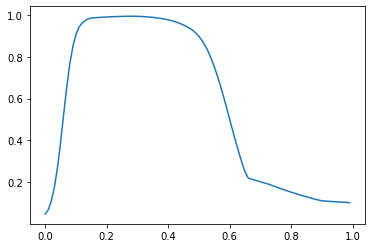

In [50]:
x = np.arange(0, 1, .01, dtype=np.float32)
y = torch.sigmoid(model(torch.from_numpy(x).unsqueeze(1).unsqueeze(1))).detach().numpy()
plt.plot(x, y)

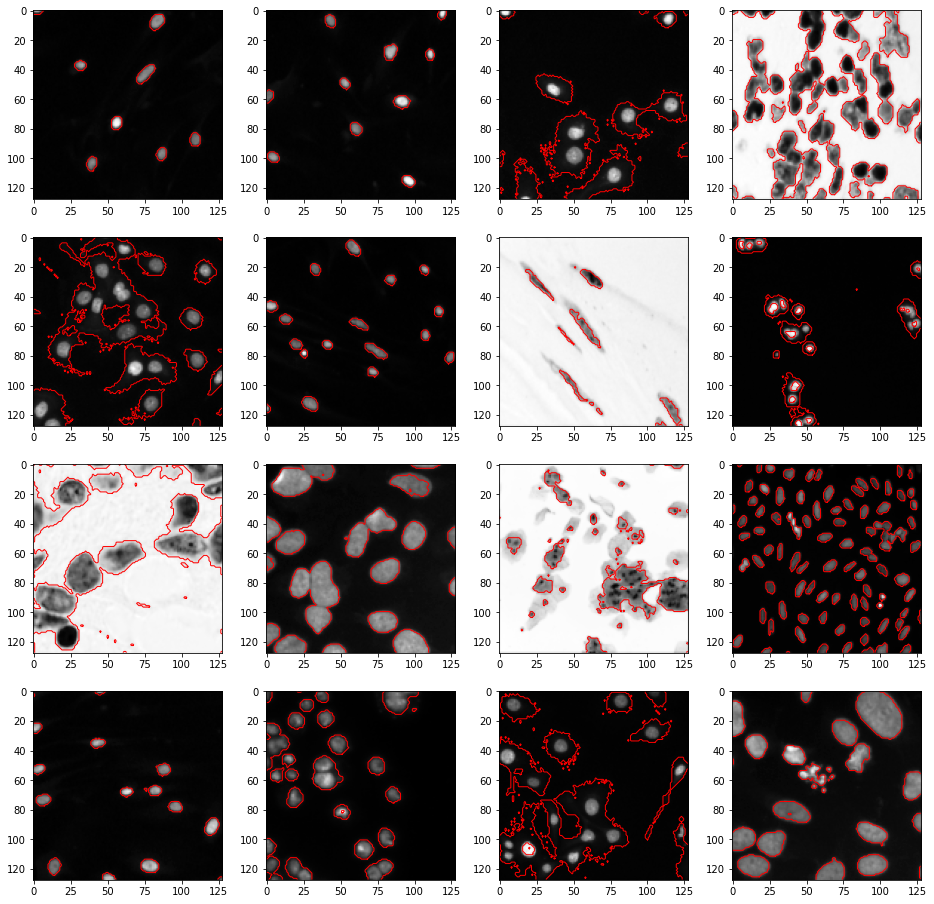

In [53]:
def plot_random_predicted_masks(images, predicted_masks, true_masks=None, num_images=16, random_seed=88):
    random.seed(888)
    rand_ids = random.sample(range(len(images)), num_images)
    rows = (num_images + 1) // 4
    _, subaxes = plt.subplots(rows, 4, figsize=(16, rows * 4))
    subaxes = subaxes.flatten()
    for i, img_idx in enumerate(rand_ids):
        img = images[img_idx, :, :]
        predicted_mask = predicted_masks[img_idx, :, :]
        subaxes[i].imshow(img, cmap='Greys_r')
        show_overlayed_mask(predicted_mask, subaxes[i], color='red')
        if true_masks is not None:
            true_mask = true_masks[img_idx, :, :]
            show_overlayed_mask(true_mask, subaxes[i], color='cyan')

plot_random_predicted_masks(X_cn_val, Y_cn_pred)

In [55]:
class FCN1(WeightedLossBaseline):
    def __init__(self):
        super(FCN1, self).__init__()
        
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.final = nn.Conv2d(16, 1, 1)

    def forward(self, X):
        X = X.unsqueeze(1)
        X = self.relu(self.conv1(X))
        X = self.final(X)
        X = X.squeeze()
        return X
    
wandb.init(project='test-segmentation')   

data_module = CNDataModule()

model = FCN1()
trainer = pl.Trainer(
    deterministic=True,
    gpus=1,
    logger=pl.loggers.WandbLogger(),
    max_epochs=200,
)
trainer.fit(model, data_module)
Y_cn_pred = torch.sigmoid(torch.cat(trainer.predict(model, datamodule=data_module), axis=0)).cpu().numpy() > 0.5

mean_iou, mean_dice, _, _ = compute_metrics(Y_cn_pred, Y_cn_val)

print('Model: basic U-Net')
print('IoU:  {:.3f}'.format(mean_iou))
print('Dice: {:.3f}'.format(mean_dice))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | relu  | ReLU   | 0     
1 | conv1 | Conv2d | 160   
2 | final | Conv2d | 17    
---------------------------------
177       Trainable params
0         Non-trainable params
177       Total params
0.001     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 34it [00:00, ?it/s]

Model: basic U-Net
IoU:  0.675
Dice: 0.791


In [56]:
class FCN2(WeightedLossBaseline):
    def __init__(self):
        super(FCN2, self).__init__()
        
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
        self.final = nn.Conv2d(32, 1, 1)

    def forward(self, X):
        X = X.unsqueeze(1)
        X = self.relu(self.conv1(X))
        X = self.relu(self.conv2(X))
        X = self.final(X)
        X = X.squeeze()
        return X

    
wandb.init(project='test-segmentation')   

data_module = CNDataModule()

model = FCN2()
trainer = pl.Trainer(
    deterministic=True,
    gpus=1,
    logger=pl.loggers.WandbLogger(),
    max_epochs=150,
)
trainer.fit(model, data_module)
Y_cn_pred = torch.sigmoid(torch.cat(trainer.predict(model, datamodule=data_module), axis=0)).cpu().numpy() > 0.5

mean_iou, mean_dice, _, _ = compute_metrics(Y_cn_pred, Y_cn_val)

print('Model: basic U-Net')
print('IoU:  {:.3f}'.format(mean_iou))
print('Dice: {:.3f}'.format(mean_dice))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | relu  | ReLU   | 0     
1 | conv1 | Conv2d | 160   
2 | conv2 | Conv2d | 12.8 K
3 | final | Conv2d | 33    
---------------------------------
13.0 K    Trainable params
0         Non-trainable params
13.0 K    Total params
0.052     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 34it [00:00, ?it/s]

Model: basic U-Net
IoU:  0.767
Dice: 0.861


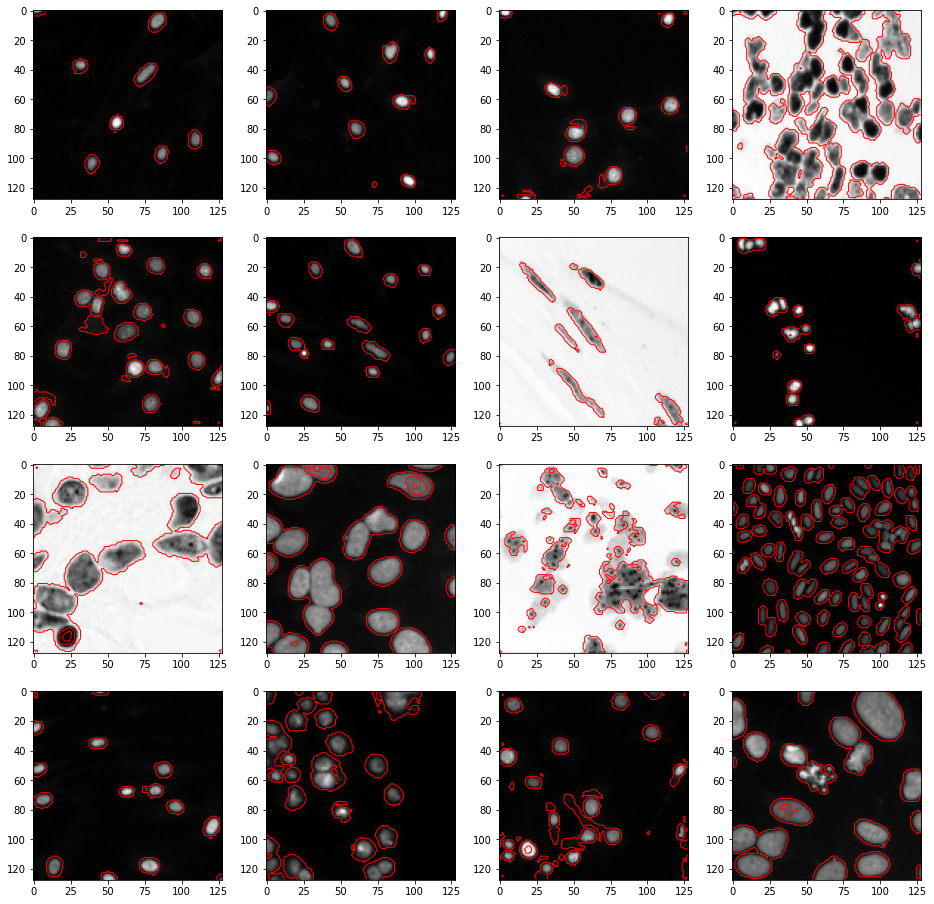

In [57]:
plot_random_predicted_masks(X_cn_val, Y_cn_pred)

In [58]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels, max_pool=2):
        super(Down, self).__init__()
        self.max_pool = nn.MaxPool2d(max_pool)
        self.conv = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.max_pool(x)
        x = self.conv(x)
        x = self.relu(x)
        return x


class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, 3, stride=2, padding=1, output_padding=1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.deconv(x)
        x = self.relu(x)
        return x

    
class UNet1(WeightedLossBaseline):
    def __init__(self):
        super(UNet1, self).__init__()
        
        self.down1 = Down(1, 16, max_pool=1)
        self.down2 = Down(16, 32)
        self.down3 = Down(32, 64)
        self.down4 = Down(64, 128)
        self.down5 = Down(128, 256)
        self.up4 = Up(256, 128)
        self.up3 = Up(128, 64)
        self.up2 = Up(64, 32)
        self.up1 = Up(32, 16)
        self.final_conv = nn.Conv2d(16, 1, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        c1 = self.down1(x)
        c2 = self.down2(c1)
        c3 = self.down3(c2)
        c4 = self.down4(c3)
        r = self.down5(c4)
        u4 = self.up4(r)
        u3 = self.up3(u4)
        u2 = self.up2(u3)
        u1 = self.up1(u2)
        out = self.final_conv(u1)
        out = out.squeeze()
        return out


wandb.init(project='test-segmentation')    

model = UNet1()
data_module = CNDataModule()
trainer = pl.Trainer(
    deterministic=True,
    gpus=1,
    logger=pl.loggers.WandbLogger(),
    max_epochs=80,
)
trainer.fit(model, data_module)
Y_cn_pred = torch.sigmoid(torch.cat(trainer.predict(model, datamodule=data_module), axis=0)).cpu().numpy() > 0.5

mean_iou, mean_dice, _, _ = compute_metrics(Y_cn_pred, Y_cn_val)

print('Model: basic U-Net')
print('IoU:  {:.3f}'.format(mean_iou))
print('Dice: {:.3f}'.format(mean_dice))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type   | Params
--------------------------------------
0 | down1      | Down   | 160   
1 | down2      | Down   | 4.6 K 
2 | down3      | Down   | 18.5 K
3 | down4      | Down   | 73.9 K
4 | down5      | Down   | 295 K 
5 | up4        | Up     | 295 K 
6 | up3        | Up     | 73.8 K
7 | up2        | Up     | 18.5 K
8 | up1        | Up     | 4.6 K 
9 | final_conv | Conv2d | 17    
--------------------------------------
784 K     Trainable params
0         Non-trainable params
784 K     Total params
3.137     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/ubuntu/miniconda3/envs/unet/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:103: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f'The dataloader, {name}, does not have many workers which may be a bottleneck.'
/home/ubuntu/miniconda3/envs/unet/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/ubuntu/miniconda3/envs/unet/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:103: UserWarni

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ubuntu/miniconda3/envs/unet/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:103: UserWarning: The dataloader, predict dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f'The dataloader, {name}, does not have many workers which may be a bottleneck.'


Predicting: 34it [00:00, ?it/s]

Model: basic U-Net
IoU:  0.653
Dice: 0.783


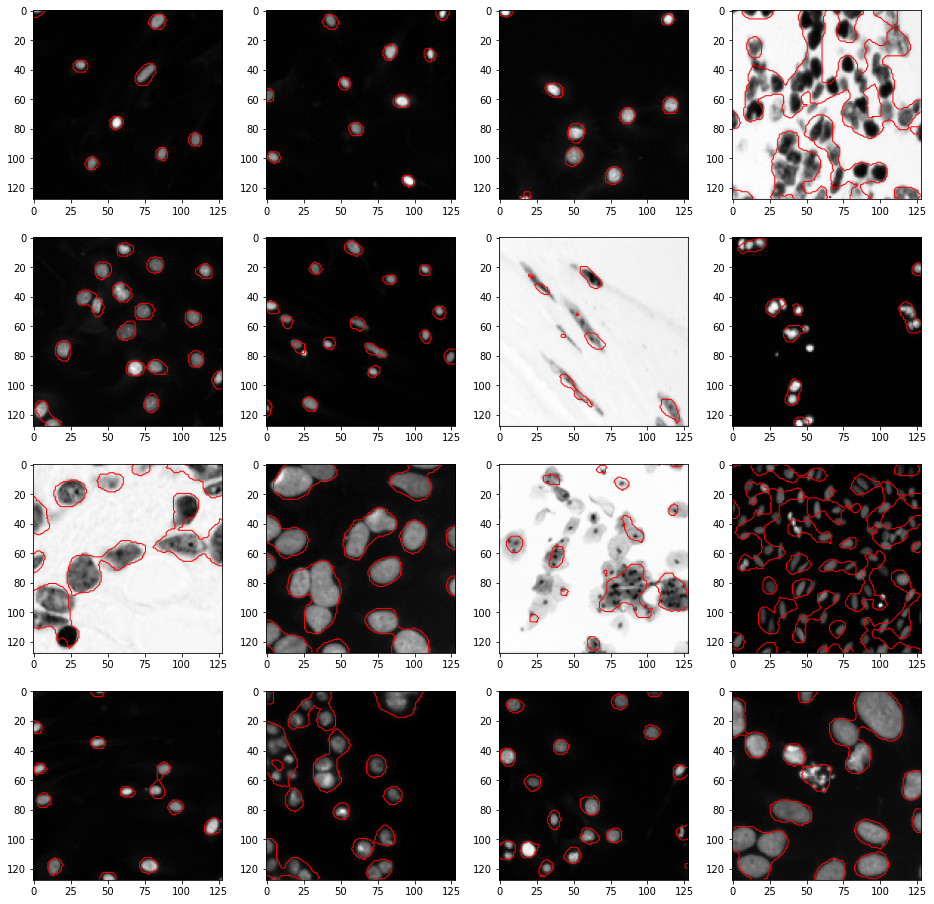

In [109]:
plot_random_predicted_masks(X_cn_val, Y_cn_pred)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type   | Params
--------------------------------------
0 | down1      | Down   | 160   
1 | down2      | Down   | 4.6 K 
2 | down3      | Down   | 18.5 K
3 | down4      | Down   | 73.9 K
4 | down5      | Down   | 295 K 
5 | up4        | Up2    | 295 K 
6 | up3        | Up2    | 147 K 
7 | up2        | Up2    | 36.9 K
8 | up1        | Up2    | 9.2 K 
9 | final_conv | Conv2d | 34    
--------------------------------------
881 K     Trainable params
0         Non-trainable params
881 K     Total params
3.524     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/ubuntu/miniconda3/envs/unet/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:103: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f'The dataloader, {name}, does not have many workers which may be a bottleneck.'
/home/ubuntu/miniconda3/envs/unet/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:103: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f'The dataloader, {name}, does not have many workers which may be a bottleneck.'


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ubuntu/miniconda3/envs/unet/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:103: UserWarning: The dataloader, predict dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f'The dataloader, {name}, does not have many workers which may be a bottleneck.'


Predicting: 34it [00:00, ?it/s]

Model: basic U-Net
IoU:  0.810
Dice: 0.891


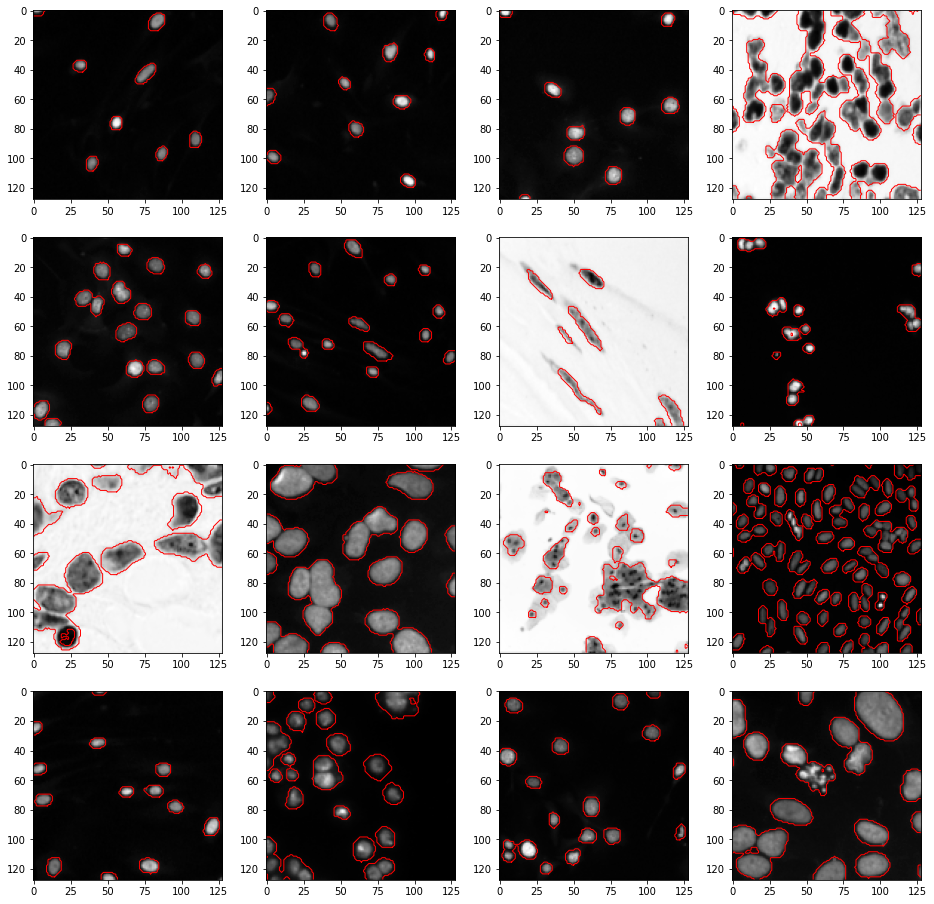

In [60]:
class Up2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up2, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, 3, stride=2, padding=1, output_padding=1)
        self.relu = nn.ReLU()
    
    def forward(self, x, c):
        x = self.deconv(x)
        x = self.relu(x)
        x = torch.cat([x, c], dim=1)
        return x

    
class UNet2(WeightedLossBaseline):
    def __init__(self):
        super(UNet2, self).__init__()
        
        self.down1 = Down(1, 16, max_pool=1)
        self.down2 = Down(16, 32)
        self.down3 = Down(32, 64)
        self.down4 = Down(64, 128)
        self.down5 = Down(128, 256)
        self.up4 = Up2(256, 128)
        self.up3 = Up2(256, 64)
        self.up2 = Up2(128, 32)
        self.up1 = Up2(64, 16)
        self.final_conv = nn.Conv2d(33, 1, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        c1 = self.down1(x)
        c2 = self.down2(c1)
        c3 = self.down3(c2)
        c4 = self.down4(c3)
        r = self.down5(c4)
        u4 = self.up4(r, c4)
        u3 = self.up3(u4, c3)
        u2 = self.up2(u3, c2)
        u1 = self.up1(u2, c1)
        out = torch.cat([x, u1], dim=1)
        out = self.final_conv(out)
        out = out.squeeze()
        return out

wandb.init(project='test-segmentation')    

model = UNet2()
data_module = CNDataModule()
trainer = pl.Trainer(
    deterministic=True,
    gpus=1,
    logger=pl.loggers.WandbLogger(),
    max_epochs=80,
)
trainer.fit(model, data_module)
Y_cn_pred = torch.sigmoid(torch.cat(trainer.predict(model, datamodule=data_module), axis=0)).cpu().numpy() > 0.5

mean_iou, mean_dice, _, _ = compute_metrics(Y_cn_pred, Y_cn_val)

print('Model: basic U-Net')
print('IoU:  {:.3f}'.format(mean_iou))
print('Dice: {:.3f}'.format(mean_dice))

plot_random_predicted_masks(X_cn_val, Y_cn_pred)

In [ ]:
# Ideas
# - Try FCN
# - Try EfficientNet
# - Try Dice loss
# - Try augmentation
# - Try weighted loss
# - Try more typical UNet

In [63]:
class NerveDataModule(pl.LightningDataModule):
    def setup(self, stage=None):
        self.train_data = TensorDataset(torch.from_numpy(X_nerve_train), torch.from_numpy(Y_nerve_train))
        self.val_data = TensorDataset(torch.from_numpy(X_nerve_val), torch.from_numpy(Y_nerve_val))
        self.predict_data = TensorDataset(torch.from_numpy(X_nerve_val))
    
    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=16)
    
    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=16)

    def predict_dataloader(self):
        return DataLoader(self.predict_data, batch_size=16)


wandb.init(project='test-segmentation')    

model = UNet2()
data_module = NerveDataModule()
trainer = pl.Trainer(
    deterministic=True,
    gpus=1,
    logger=pl.loggers.WandbLogger(),
    max_epochs=20,
)
trainer.fit(model, data_module)
Y_nerve_pred = torch.sigmoid(torch.cat(trainer.predict(model, datamodule=data_module), axis=0)).cpu().numpy() > 0.5

mean_iou, mean_dice, _, _ = compute_metrics(Y_nerve_pred, Y_nerve_val)

print('Model: basic U-Net')
print('IoU:  {:.3f}'.format(mean_iou))
print('Dice: {:.3f}'.format(mean_dice))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type   | Params
--------------------------------------
0 | down1      | Down   | 160   
1 | down2      | Down   | 4.6 K 
2 | down3      | Down   | 18.5 K
3 | down4      | Down   | 73.9 K
4 | down5      | Down   | 295 K 
5 | up4        | Up2    | 295 K 
6 | up3        | Up2    | 147 K 
7 | up2        | Up2    | 36.9 K
8 | up1        | Up2    | 9.2 K 
9 | final_conv | Conv2d | 34    
--------------------------------------
881 K     Trainable params
0         Non-trainable params
881 K     Total params
3.524     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 278it [00:00, ?it/s]

Model: basic U-Net
IoU:  nan
Dice: nan


/home/ubuntu/miniconda3/envs/unet/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/ubuntu/miniconda3/envs/unet/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
